In [203]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
plt.style.use("paper.mplstyle")

from scipy.interpolate import UnivariateSpline
from scipy.optimize import broyden1
from scipy import integrate


In [204]:
hist1000 = np.load("data/e_d_theta_hist/ch5_m1000_f1.000000_f_tot_e_d_theta_hist.npy")
hist500  = np.load("data/e_d_theta_hist/ch5_m500_f1.000000_f_tot_e_d_theta_hist.npy")
# normalize
hist1000 = hist1000 / np.sum(hist1000)
hist500  = hist500 / np.sum(hist500)

In [205]:
pdf0_1000 = np.sum(hist1000, axis=0)
pdf1_1000 = np.sum(hist1000, axis=1)

In [206]:
theta_bins   = np.linspace(0,180,361)
theta_cents  = (theta_bins[1:]+theta_bins[:-1])/2.
theta_widths = theta_bins[1:]-theta_bins[:-1]

e_bins   = np.logspace(0.5, 6.5, 61)
e_cents  = (e_bins[1:]+e_bins[:-1])/2.
e_widths = e_bins[1:]-e_bins[:-1]

In [207]:
def cdf(val, edges, pmf):
    widths   = edges[1:]-edges[:-1]
    density  = pmf/widths
    try:
        i        = np.max(np.where(val>=edges))
    except ValueError:
        i = 0
    try:
        cdf = np.sum(widths[:i]*density[:i]) + (density[i] * ((val-edges[i])))
    except IndexError:
        cdf = np.sum(widths*density)
    return cdf

def pmf(val, edges, pmf):
    return pmf[np.digitize(val, edges)-1]

In [208]:
def sortTogether(sortArray, otherArray):
    """
    sortArray  array_like: array to be sorted. Must be iterable
    otherArray array_like: array whose values will stay in the same place wrt those in sortArray
    """
    assert len(sortArray)==len(otherArray)
    list1, list2 = zip(*sorted(zip(sortArray, otherArray)))
    return np.asarray(list1), np.asarray(list2)

In [209]:
# def remove_zeros(arr):
#     where = np.argwhere(arr==0)
#     m = (where > np.argmax(arr)).flatten()
#     try:
#         i0 = int(max(where[~m]))+1
#     except:
#         i0 = 0
#     try:
#         i1 = int(min(where[m]))
#     except:
#         i1 = len(arr)-1

#     # Pad arr on both ends for splining
#     if i0 !=0:
#         a0 = np.full(i0-1, arr[i0])
#     else:
#         a0 = []
#     a1 = np.full(len(arr)-i1+1, arr[i1-1])
#     a  = np.hstack([a0,arr[i0:i1],a1])
#     print(len(a))
#     print(a)
#     return a

In [210]:
class hist():
    
    def __init__(self, ch, m):
        
        self.ch   = ch
        self.m    = m
        
        hist          = np.load("data/e_d_theta_hist/ch%d_m%d_f1.000000_f_tot_e_d_theta_hist.npy" % (ch, m))
        self.hist     = hist / np.sum(hist)
        self.thetapmf = np.sum(self.hist, axis=0)
        self.epmf     = np.sum(self.hist, axis=1)[::-1]
        self.thetapmf = np.concatenate([[0], np.cumsum(self.thetapmf)])
        self.ecmf     = np.concatenate([[0], np.cumsum(self.epmf)])
                                        
    def get_e_cdf(self, val):
        return cdf(val, e_bins, self.epmf)

    def get_theta_cdf(self, val):
        return cdf(val, theta_bins, self.thetapmf)
    
    def get_e_pmf(self, val):
        return pmf(val, e_bins, self.epmf)
    

In [11]:
m0 = 500
m1 = 1000
mi = 700

h0 = hist(8,m0)
h1 = hist(8,m1)

def cum_intercept(cum_val, cdf, guess):
    func = lambda x: cdf(x)-cum_val
    return float(broyden1(func, guess))

# def interp(widths, h0, h1)
y0 = [np.sum(h0.epmf[:i+1]) for i in range(len(e_widths))]
y1 = [np.sum(h1.epmf[:i+1]) for i in range(len(e_widths))]
ys = np.asarray(list(set(y0)|set(y1)))
xpairs = []
for y in ys:
    __ = cum_intercept(y, h1.e_cdf,700)

    _ = cum_intercept(y, h0.e_cdf,700)
    xpairs.append((_, __))

a = float(abs(m0-mi))/abs(m1-m0)
b = 1-a
xs = []
vals = []
for pair in xpairs:
    x0, x1 = pair
    xs.append(a*x0+b*x1)
    _ = h0.e_pmf(x0)*h1.e_pmf(x1)/(a*h1.e_pmf(x1)+b*h0.e_pmf(x0))
    vals.append(_)
xs, vals = sortTogether(xs, vals)
vals = vals / np.sum(vals)
pdf = 0
def get_have_widths(have_edges, want_edges):
    last_le    = have_edges[-1]
    last_re    = want_edges[np.min(np.where(want_edges>last_le))]
    have_edges = np.append(have_edges, last_re)
    return np.diff(have_edges)
have_widths = get_have_widths(xs, e_bins)

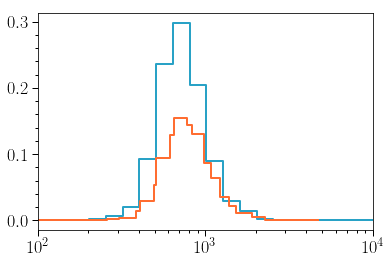

In [12]:
def rebin(old_left_edges, old_vals, old_widths, new_bins, debug=False):
    density   = old_vals / old_widths
    have_tups = [(edge, val, width) for edge,val,width in zip(old_left_edges,density,old_widths)]
    want_tups = [(edge, None, None) for edge in new_bins]
    tups      = sorted(have_tups+want_tups, key=lambda x: x[0])
    bin_tups  = []
    remainder = None
    tots      = []
    for edge, val, width in tups:
        if val is not None:
            if debug:
                print("have")
            bin_tups.append((edge,val,width))
        else:
            if debug:
                print("want")
                print("\tbin_tups=="+str(bin_tups))
                print("\tedge==%f" % edge)
            if len(bin_tups) != 0:
                tot = np.sum(val*w for edge, val, w in bin_tups)
                coef = (edge - bin_tups[-1][0]) / (bin_tups[-1][2])
                if debug:
                    print("\tval==%f" % (bin_tups[-1][1]))
                    print("\tcoef==%f" % coef)
                tot      += coef * bin_tups[-1][1] * bin_tups[-1][2]
                remainder = (1-coef) * bin_tups[-1][1] * bin_tups[-1][2]
                if debug:
                    print("\tremainder==%f" % remainder)
            else:
                tot = 0
            if remainder is not None:
                tot += remainder
            tots.append(tot)
            bin_tups = []
    return tots[1:] / np.sum(tots[1:])

new_vals = rebin(xs, vals, have_widths, e_bins)
plt.step(e_cents, new_vals, where="mid")
# plt.step(e_cents, new_vals, where="mid")
plt.step(xs, vals , where="post")
plt.semilogx()
plt.xlim(1e2,1e4)
plt.show()

In [197]:

[cdf(e, e_bins, tots[1:]) for e in np.logspace(2,4, 100)]

[0.0005457138266617917,
 0.0006103839227937855,
 0.0006781333342360825,
 0.0007491086849052627,
 0.0008234635803260667,
 0.000902165832288118,
 0.001000308529724029,
 0.0011031243655791618,
 0.001210835854857235,
 0.0013236761077813773,
 0.0014505357859808166,
 0.0016630909320433456,
 0.0018857670513949536,
 0.002119046061797775,
 0.0023634328278909554,
 0.0026600814355564927,
 0.0032064964856911558,
 0.0037789294997735944,
 0.004378619342743228,
 0.005006863869026174,
 0.005864248932021762,
 0.007578159941214375,
 0.009373680113324186,
 0.011254695330077988,
 0.013225276502386394,
 0.0161605149687391,
 0.02190959164915568,
 0.027932414943555917,
 0.034242019503038165,
 0.040852060633425114,
 0.05312159889069906,
 0.07874037349940853,
 0.10557900534666051,
 0.13369557885316397,
 0.163150944173045,
 0.20531250132946055,
 0.27096866624163424,
 0.3397510988713823,
 0.41180865880950135,
 0.4872972937082606,
 0.5664255937836905,
 0.6493910701876193,
 0.7363070102060746,
 0.8273615181379279,

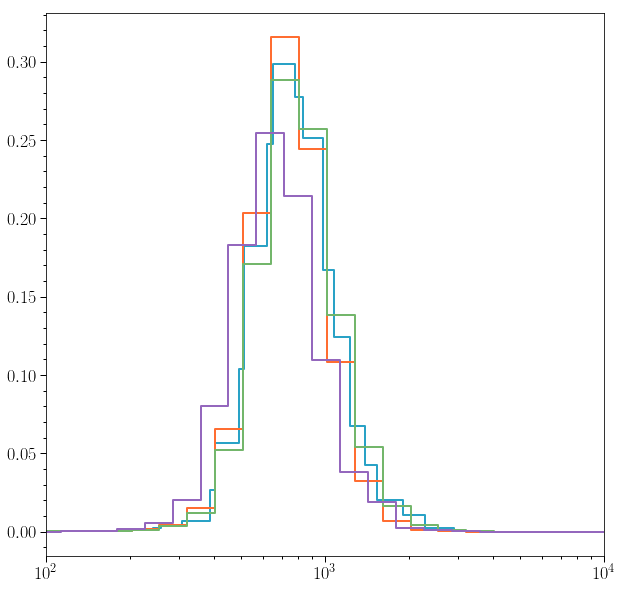

In [25]:
plt.step(xs,vals,where="post")
plt.step(e_cents, h0.epmf*e_widths, where="mid")
plt.step(e_cents, h1.epmf*e_widths, where="mid")
# plt.step(e_bins[:-1], h0.epmf*e_widths, where = "post")
plt.semilogx()
plt.xlim(1e2,1e4)
plt.show()

In [41]:
pmf(1000, left_edges, vals)

0.16726465981385416

[1.39737182e+06 1.21680017e+06 1.42538439e+06 2.37433581e+06
 1.80123604e+06 1.73898348e+05 1.52567185e+05 3.67999841e+05
 1.96806618e+06 1.16069499e+05 1.00991433e+06 2.04264544e+05
 1.83620682e+06 1.66733135e+06 1.10101367e+06 1.32061572e+06
 1.39939142e+06 9.75319745e+05 1.44388452e+06 1.45991311e+06
 2.40578113e+06 6.26239433e+05 5.05575256e+05 5.58550864e+05
 1.88325607e+06 1.40125532e+06 2.06732824e+05 1.48743322e+06
 3.70824961e+05 3.39395838e+05 4.38732342e+05 2.16566643e+06
 2.21700645e+06 8.00405530e+05 2.09754921e+06 7.30422366e+05
 2.38371646e+06 2.06788037e+06 1.33179231e+06 3.11399979e+05
 2.88858807e+05 2.13922703e+06 1.85807608e+05 4.34389524e+05
 1.61476233e+06 4.76045091e+05 5.78013004e+05 8.01084866e+05
 6.10859457e+05 1.74990606e+06 2.59005499e+05 5.50549717e+05
 1.88819481e+06 2.01228701e+06 1.74046525e+06 1.56236010e+06
 3.07930493e+05 1.75651678e+06 1.37979195e+06 4.41197541e+05
 2.09868624e+06 1.77100336e+06 1.16584882e+05 1.85973639e+06
 3.47574779e+05 5.192878

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([-5.  , -4.95, -4.9 , -4.85, -4.8 , -4.75, -4.7 , -4.65, -4.6 ,
        -4.55, -4.5 , -4.45, -4

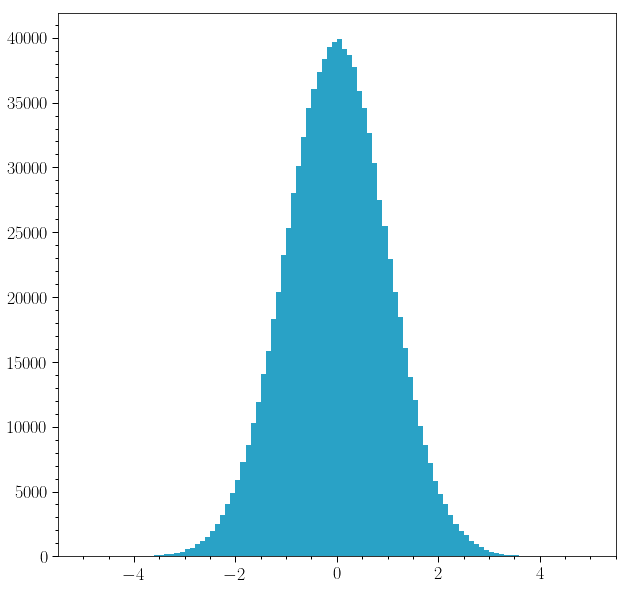

In [52]:
def centers(arr):
    return arr[:-1] + np.diff(arr) / 2.

a = np.random.randn(1000000)
h = plt.hist(a, bins=np.linspace(-5., 5., 101))
bins = e_bins
b = np.random.choice(centers(h[1]), p=h[0] / np.sum(h[0]), size=1000) 
inds = np.digitize(b, bins=bins) -1
wiggle = np.concatenate(np.asarray([np.random.uniform(low=bins[ind-1], high=bins[ind+1], size = 1) for ind in inds]))
print(wiggle)
b += wiggle
plt.hist(b, bins=np.linspace(-5., 5., 201))


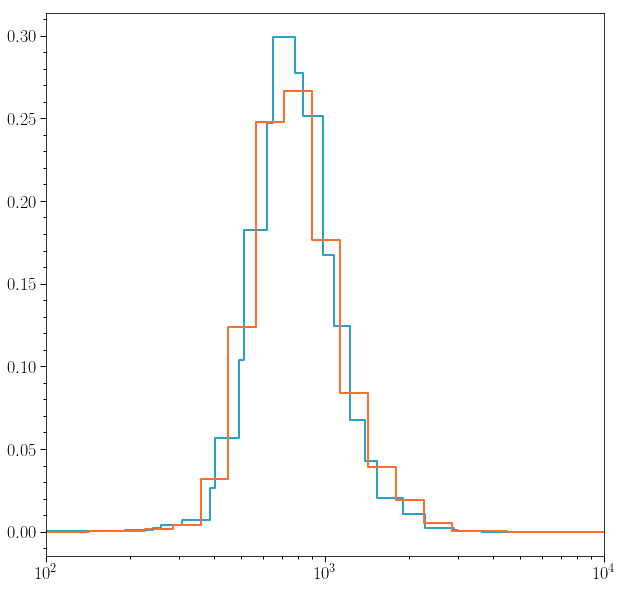

In [56]:
a = pmf(np.logspace(2,4, 100000), left_edges, vals)
h = np.histogram(np.logspace(2,4, 100000), e_bins, weights=a, normed=True)
plt.step(xs,vals,where="post")
plt.step(e_cents, h[0]*e_widths, where="pre")
# plt.step(e_cents, h0.epmf*e_widths, where="mid")
# plt.step(e_cents, h1.epmf*e_widths, where="mid")
plt.xlim(1e2,1e4)

plt.semilogx()
plt.show()

In [131]:
[cdf(val, e_bins, tots[1:]) for val in np.logspace(2,6, 1000)]

[0.01765803591033397,
 0.018286134997019966,
 0.018920051657405634,
 0.01955983977496974,
 0.0202055537322699,
 0.020857248415565566,
 0.021514979219483168,
 0.02217880205172472,
 0.022848773337820122,
 0.02352495002592311,
 0.024207389591652292,
 0.024896150042976385,
 0.02559128992514496,
 0.026292868325664968,
 0.027000944879322912,
 0.027715579773254277,
 0.02843683375205924,
 0.02916476812296607,
 0.02989944476104235,
 0.03064092611445414,
 0.03138927520977457,
 0.032144555657340826,
 0.03290683165666123,
 0.03367616800187227,
 0.03445263008724585,
 0.035246400459965375,
 0.036443892526279546,
 0.03765247599281741,
 0.03887225359024625,
 0.04010332900074405,
 0.04134580686681337,
 0.04259979280017538,
 0.04386539339074725,
 0.0451427162157025,
 0.04643186984861441,
 0.04773296386868603,
 0.04904610887006364,
 0.05037141647123772,
 0.051708999324530575,
 0.05305897112567151,
 0.054421446623461725,
 0.055796541629527636,
 0.05718437302816508,
 0.05858505878627469,
 0.059998717963388

In [213]:
def cmf(pmf):
    return np.concatenate([[0], np.cumsum(pmf)])
def pmf(cmf):
    return np.diff(cmf)
def interp(x, x0, x1, y0, y1):
    r = np.empty(shape=np.shape(x))
    mask_0 = x == x0
    mask_1 = x == x1
    mask_2 = ~np.logical_or(mask_0, mask_1)
    r[mask_0] = y0[mask_0]
    r[mask_1] = y1[mask_1]
    r[mask_2] = y0[mask_2]+(x[mask_2]-x0[mask_2])*(y1[mask_2]-y0[mask_2])/(x1[mask_2]-x0[mask_2])
    return r

In [214]:
def compute_interp_cmf(cmf_0, cmf_1, edges_0, edges_1, x):
    
    print("cmf_0=="+str(cmf_0))
    print("cmf_1=="+str(cmf_1))
    print("edges_0=="+str(edges_0))
    print("edges_0=="+str(edges_1))
    
    y_vals_0, unique_y_index_0 = np.unique(cmf_0, return_index=True)
    y_vals_1, unique_y_index_1 = np.unique(cmf_1, return_index=True)
    y_vals = np.unique(np.concatenate([y_vals_0, y_vals_1]))

    x_0_vals = np.empty(shape=len(y_vals))
    x_1_vals = np.empty(shape=len(y_vals))
    mask_0 = np.isin(y_vals, cmf_0, assume_unique=True)
    mask_1 = np.isin(y_vals, cmf_1, assume_unique=True)
    
    print("mask_0=="+str(mask_0))
    print("mask_1=="+str(mask_1))
    
    x_0_vals[mask_0] = edges_0[unique_y_index_0]
    x_1_vals[mask_1] = edges_1[unique_y_index_1]
    
    y_positions_0 = np.digitize(y_vals[~mask_0], bins=cmf_0) - 1
    y_positions_1 = np.digitize(y_vals[~mask_1], bins=cmf_1) - 1
    
    print("y_positions_0=="+str(y_positions_0))
    print("y_positions_1=="+str(y_positions_1))
    
    intermediate_x_0 = interp(y_vals[~mask_0],
           cmf_0[y_positions_0], cmf_0[y_positions_0+1],
           edges_0[y_positions_0], edges_0[y_positions_0+1])
    
    intermediate_x_1 = interp(y_vals[~mask_1],
           cmf_1[y_positions_1], cmf_1[y_positions_1+1],
           edges_1[y_positions_1], edges_1[y_positions_1+1])
    
    x_0_vals[~mask_0] = intermediate_x_0
    x_1_vals[~mask_1] = intermediate_x_1

    x_vals = x_0_vals * (1.0-x) + x_1_vals * x
    
    return y_vals, x_vals

In [215]:
def rebin_cmf(cmf_0, edges_0, edges_1):
    r = np.empty(shape=len(edges_1))
    mask_less = edges_1 < np.amin(edges_0)
    mask_more = edges_1 >= np.amax(edges_0)
    mask = ~np.logical_or(mask_less, mask_more)
    r[mask_less] = 0.0
    r[mask_more] = 1.0
    
    x_pos = np.digitize(edges_1[mask], bins=edges_0) - 1
    y_vals = interp(edges_1[mask],
           edges_0[x_pos], edges_0[x_pos+1],
           cmf_0[x_pos], cmf_0[x_pos])
    r[mask] = y_vals
    return r

In [11]:
# Prepare test data

bins = np.linspace(0,10,13)

data_3 = np.random.normal(3, 1.0, 100)
data_5 = np.random.normal(5, 1.0, 100)

hist_3 = np.histogram(data_3, bins=bins)[0].astype(float)
hist_5 = np.histogram(data_5, bins=bins)[0].astype(float)

pmf_3 = hist_3 / np.sum(hist_3)
pmf_5 = hist_5 / np.sum(hist_5)

cmf_3 = cmf(pmf_3)
cmf_5 = cmf(pmf_5)

[ 3.  7. 17. 36. 26.  9.  2.  0.  0.  0.  0.  0.]
[ 0.  0.  1.  5. 14. 27. 31. 17.  4.  1.  0.  0.]
[0.03 0.07 0.17 0.36 0.26 0.09 0.02 0.   0.   0.   0.   0.  ]
[0.   0.   0.01 0.05 0.14 0.27 0.31 0.17 0.04 0.01 0.   0.  ]
cmf_0==[0.   0.03 0.1  0.27 0.63 0.89 0.98 1.   1.   1.   1.   1.   1.  ]
cmf_1==[0.   0.   0.   0.01 0.06 0.2  0.47 0.78 0.95 0.99 1.   1.   1.  ]
edges_0==[ 0.          0.83333333  1.66666667  2.5         3.33333333  4.16666667
  5.          5.83333333  6.66666667  7.5         8.33333333  9.16666667
 10.        ]
edges_0==[ 0.          0.83333333  1.66666667  2.5         3.33333333  4.16666667
  5.          5.83333333  6.66666667  7.5         8.33333333  9.16666667
 10.        ]
mask_0==[ True False  True False  True False  True False  True False  True False
  True False  True]
mask_1==[ True  True False  True False  True False  True False  True False  True
 False  True  True]
y_positions_0==[0 1 2 3 4 5 6]
y_positions_1==[3 4 5 6 7 8]


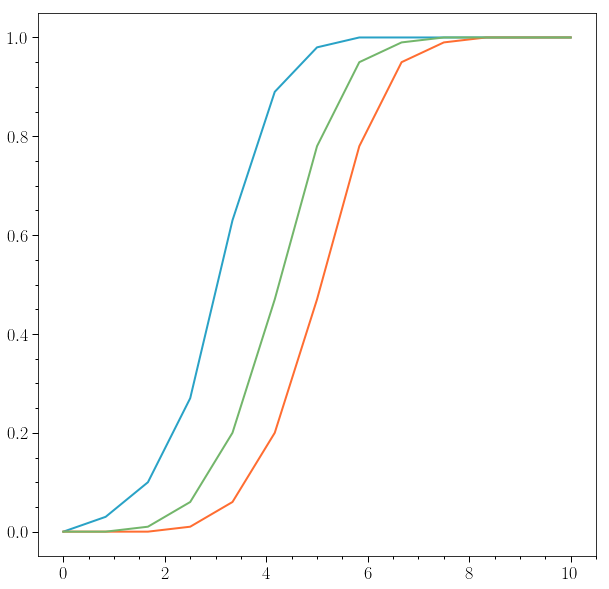

In [12]:
print(hist_3)
print(hist_5)
print(pmf_3)
print(pmf_5)

cmf_4, edges_4 = compute_interp_cmf(cmf_3, cmf_5, bins, bins, 0.5)
cmf_4 = rebin_cmf(cmf_4, edges_4, bins)
plt.plot(bins, cmf_3)
plt.plot(bins, cmf_5)
plt.plot(bins, cmf_4)

In [216]:
h_500  = hist(8, 500)
h_1000 = hist(8, 1000)

compute_interp_cmf(h_500.ecmf, h_1000.ecmf, e_bins, e_bins, 0.6)

cmf_0==[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.94689343e-06 1.45472834e-05
 3.67743242e-05 8.12581545e-05 2.00009008e-04 3.60226786e-04
 5.91491938e-04 8.95017429e-04 1.50899579e-03 2.97236157e-03
 7.37281494e-03 2.24388072e-02 8.80441101e-02 2.91723591e-01
 6.07232662e-01 8.51244348e-01 9.59335483e-01 9.91623566e-01
 9.98559403e-01 9.99817085e-01 9.99968545e-01 9.99996855e-01
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00]
cmf_1==[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.000000

IndexError: index 61 is out of bounds for axis 1 with size 61